In [1]:
!pip install --upgrade opencv-contrib-python > /dev/null 
!pip install segmentation-models-pytorch > /dev/null 
!pip install albumentations > /dev/null 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate


height,width = (512, 512)

torch.cuda.is_available()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

In [3]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))

In [4]:
len(y)

2841

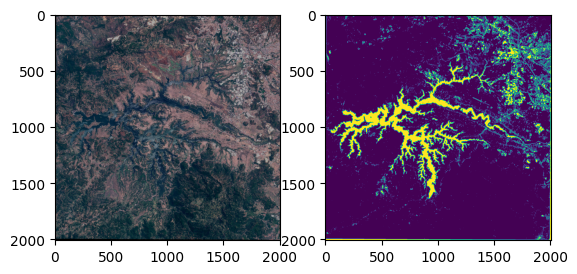

In [5]:
img = Image.open(X[0])
mask = Image.open(y[0]).convert('L')
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)

In [6]:
X_=X[0]
y_=y[0]

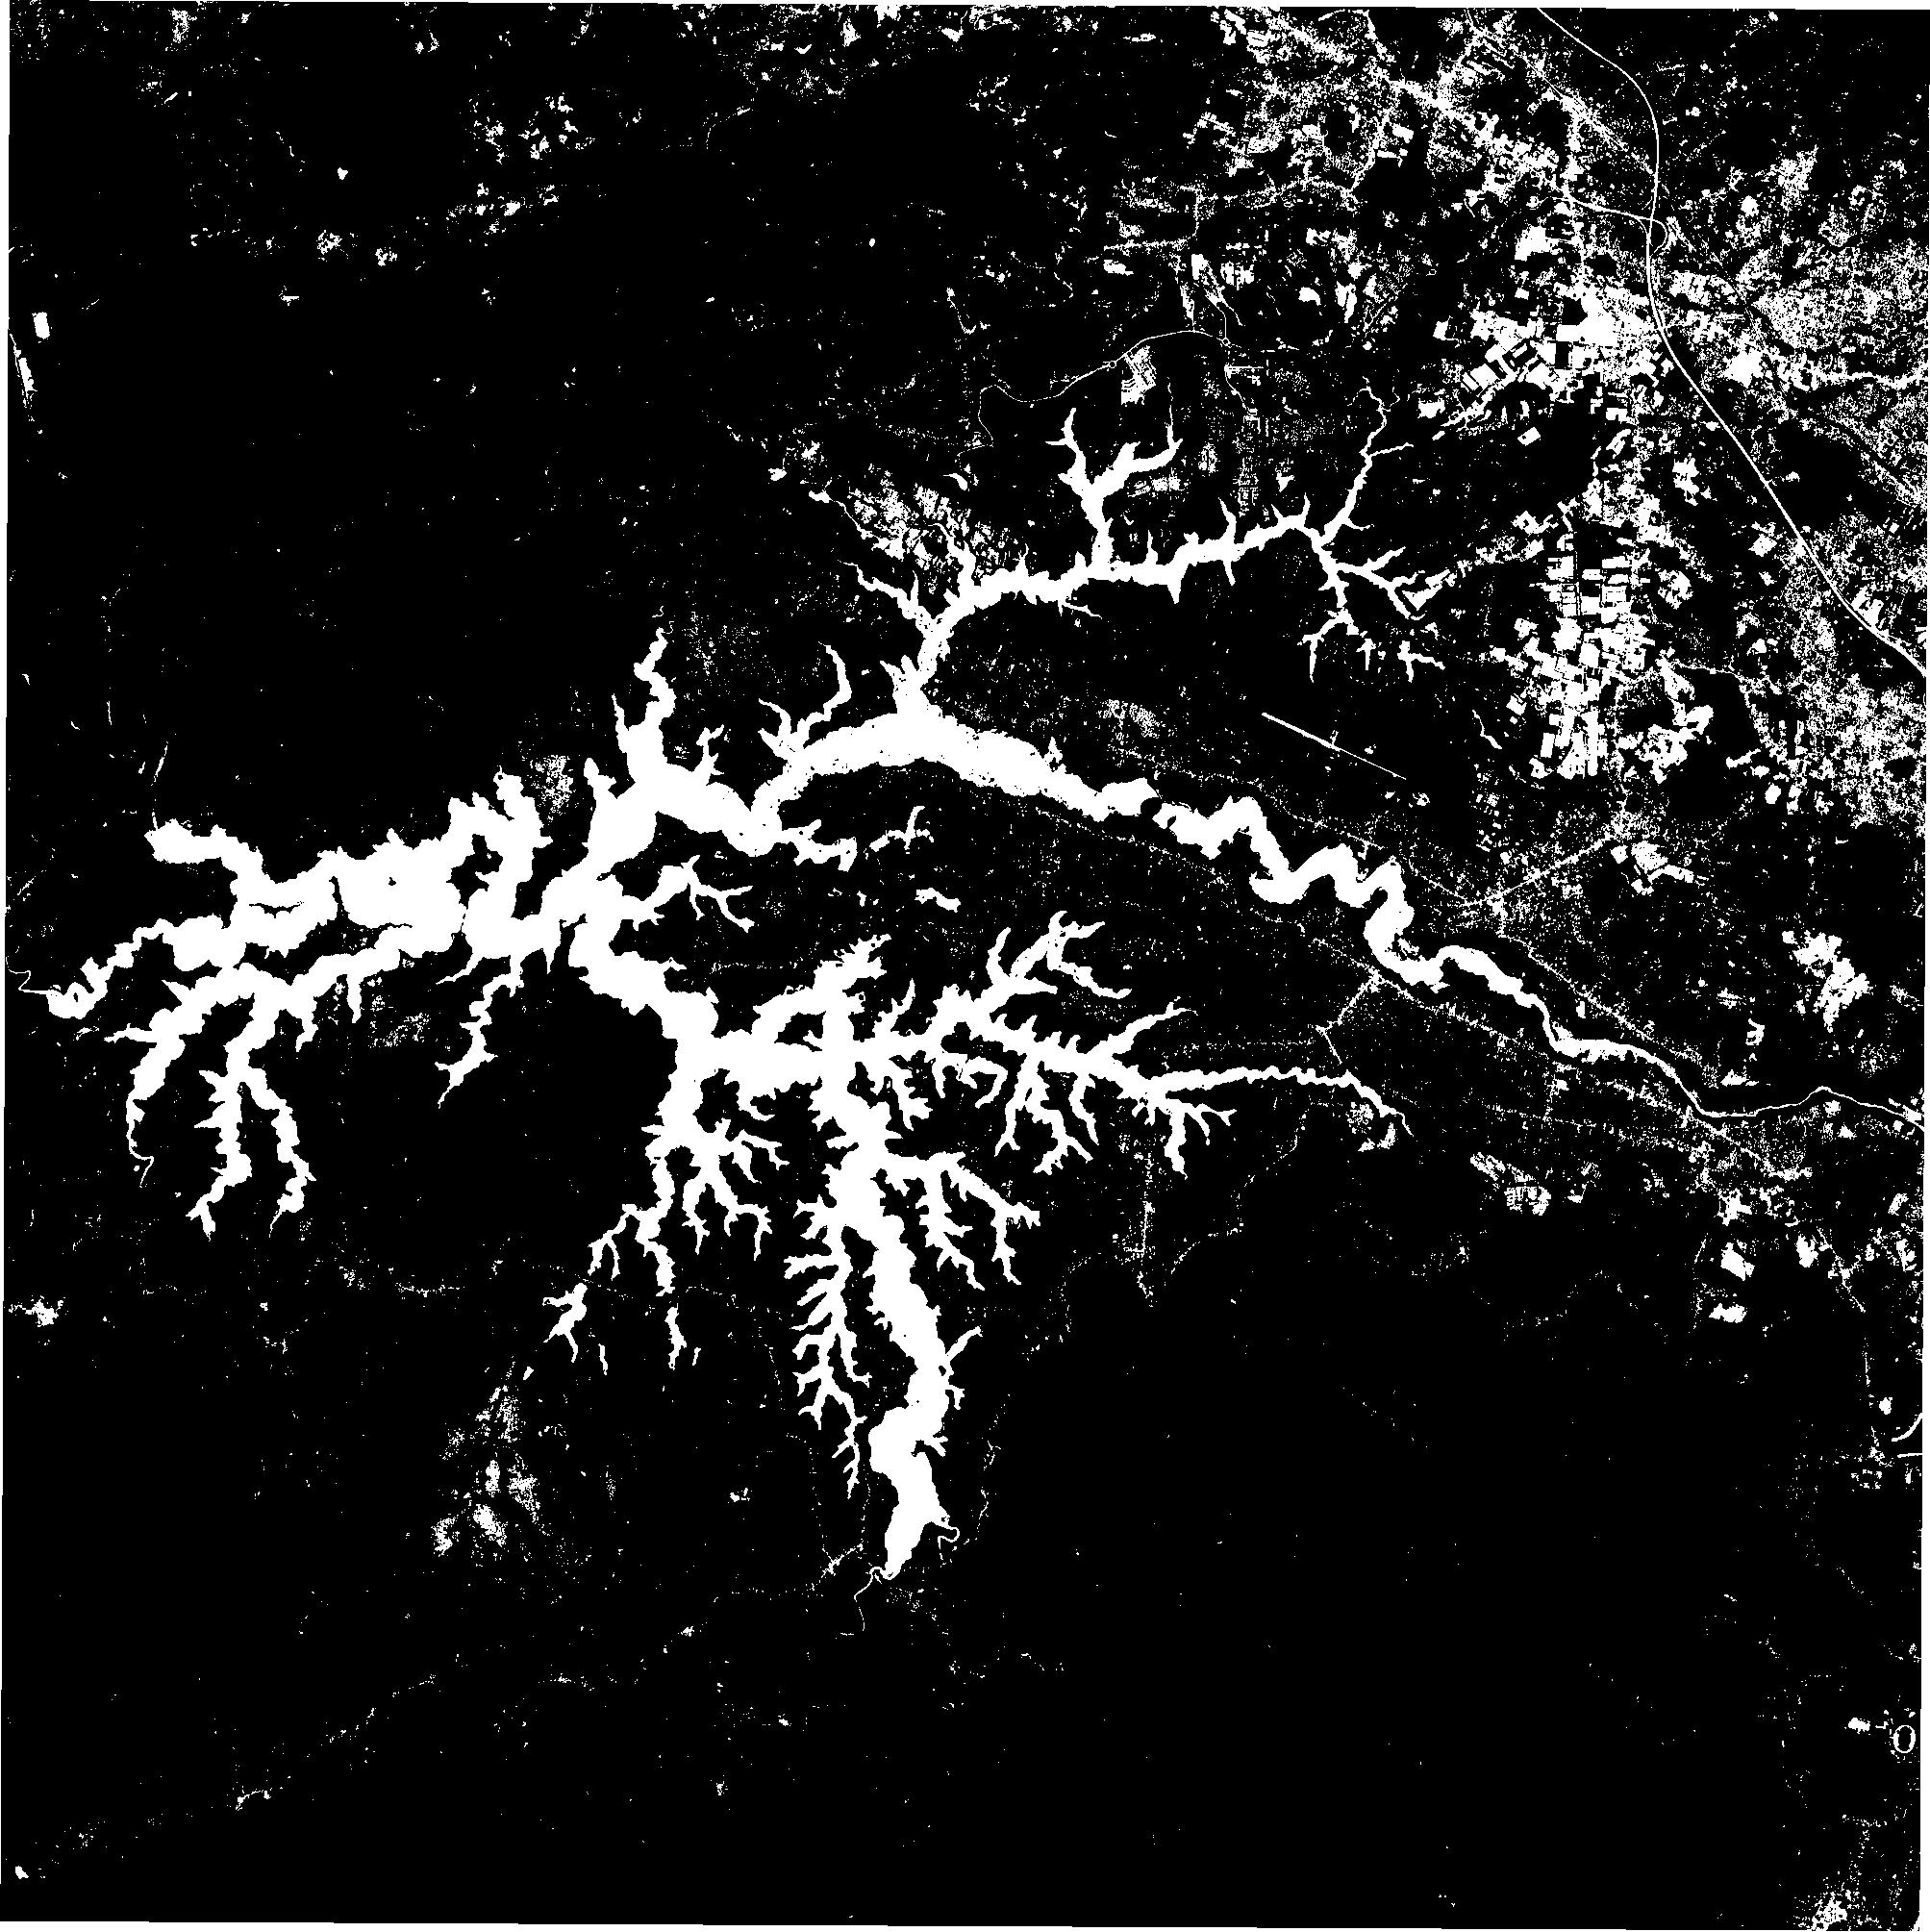

In [7]:
img = Image.open(X_)
mask = Image.open(y_).convert('L')

mask

In [8]:
img, mask = np.array(img), np.array(mask)
transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
        ])
transformed = transform(image=img, mask=mask)
img = transformed['image']
mask = transformed['mask']

In [9]:
mask.shape

(512, 512)

In [10]:
img = np.transpose(img, (2, 0, 1))
img = img/255.0
img = torch.tensor(img)

mask = np.expand_dims(mask, axis=0)
mask = mask/255.0
mask = torch.tensor(mask)

In [11]:
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [12]:
class Load_Data(Dataset):
    def __init__(self, image_list, mask_list):
        super().__init__()

        self.images_list = image_list
        self.mask_list = mask_list
        self.len = len(image_list)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            #A.RandomBrightnessContrast(p=0.5),
            #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        
    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx])
        mask = Image.open(self.mask_list[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
train_dataset = Load_Data(X_train, y_train)
valid_dataset = Load_Data(X_val, y_val)

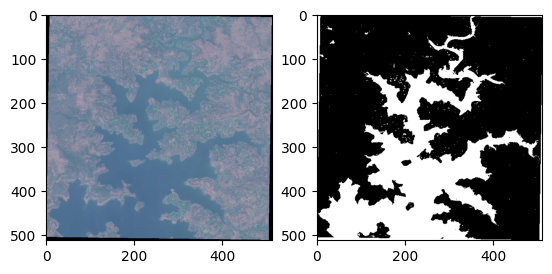

In [15]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


In [16]:
DEVICE='cuda'

EPOCHS=5
BATCH_SIZE=16
LR=0.001

ratio=0.5 
sample_num=2

ENCODER='resnet50'
WEIGHTS='imagenet'

In [17]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)


In [18]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [20]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [21]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [22]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)


In [23]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
#torch.optim.Adam(model.parameters(),lr=LR)

100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


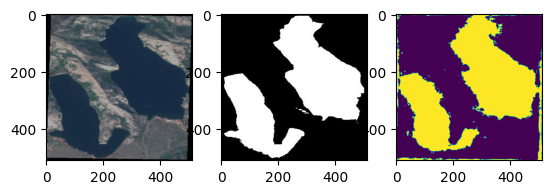

Model Saved


100%|██████████| 18/18 [00:05<00:00,  3.07it/s]


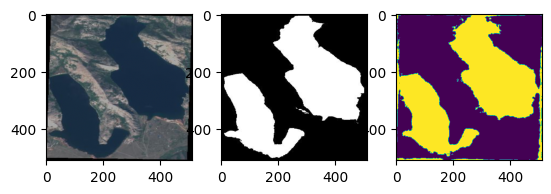

Model Saved


100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


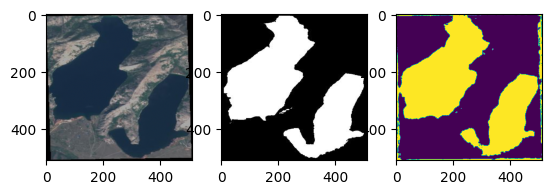

Model Saved


100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


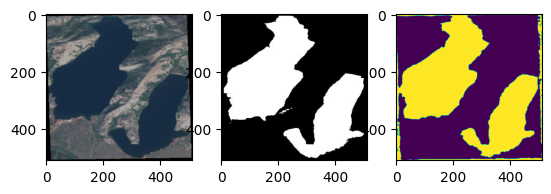

Model Saved


100%|██████████| 18/18 [00:05<00:00,  3.07it/s]


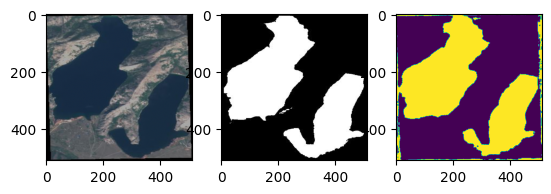

Model Saved


In [24]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

try:
    os.mkdir("/kaggle/working/modelPerformance")
except:
    print("File Exists!")

try:
    os.mkdir("/kaggle/working/modelPerformance/" + ENCODER)
except:
    print("File Exists!")

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    
    if valid_dice < best_val_dice_loss: #or valid_bce < best_val_bce_loss
        torch.save(model.state_dict(),"/kaggle/working/modelPerformance/{}/model_{:.5f}dice.pt".format(ENCODER, valid_dice))
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

Text(0.5, 1.0, 'Predicted Mask')

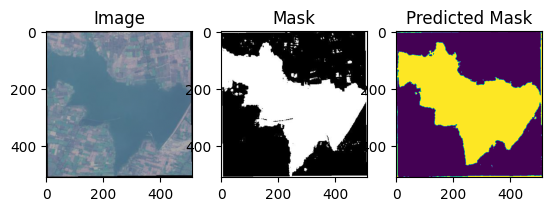

In [25]:
num=10
ratio=0.5
PATH = f"/kaggle/working/modelPerformance/{ENCODER}/"
model.load_state_dict(torch.load(PATH + os.listdir(PATH)[-1]))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[0].set_title('Image')
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[1].set_title('Mask')
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
axarr[2].set_title('Predicted Mask')